# Financial Inclusion Forecasting Framework

This notebook implements comprehensive forecasting for Ethiopia's financial inclusion indicators using:
1. **Trend regression** (linear and log-linear)
2. **Event-augmented models** (trend + event impacts)
3. **Scenario analysis** (optimistic, base, pessimistic)
4. **Uncertainty quantification** (confidence intervals and scenario ranges)

## Target Indicators
- **Account Ownership Rate**: % of adults with account at financial institution or mobile money
- **Digital Payment Usage**: % of adults who made or received digital payment

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import sys
sys.path.append('../src')
from impact_model_utils import extract_events, extract_indicators, parse_impact_links
from forecast_utils import *

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Section 1: Target Definition & Data Preparation

In [2]:
# Load data
df = pd.read_csv('../data/raw/ethiopia_fi_unified_data.csv')

# Extract components
indicators_df = extract_indicators(df)
events_df = extract_events(df)
impact_links_df = parse_impact_links(df)

print(f"Total observations: {len(indicators_df)}")
print(f"Total events: {len(events_df)}")
print(f"Total impact links: {len(impact_links_df)}")

Total observations: 30
Total events: 10
Total impact links: 14


In [3]:
# Prepare time series for Account Ownership Rate
acc_own_ts = prepare_time_series(indicators_df, 'ACC_OWNERSHIP')

print("\n=== ACCOUNT OWNERSHIP RATE ===")
print("Historical observations:")
display(acc_own_ts)

print(f"\nData points: {len(acc_own_ts)}")
print(f"Time span: {acc_own_ts['year'].min()} - {acc_own_ts['year'].max()}")
print(f"Current value (2024): {acc_own_ts[acc_own_ts['year']==2024]['value'].values[0]:.1f}%")


=== ACCOUNT OWNERSHIP RATE ===
Historical observations:


,year,value
0,2014,22.0
1,2017,35.0
2,2021,46.0
5,2024,49.0



Data points: 4
Time span: 2014 - 2024
Current value (2024): 49.0%


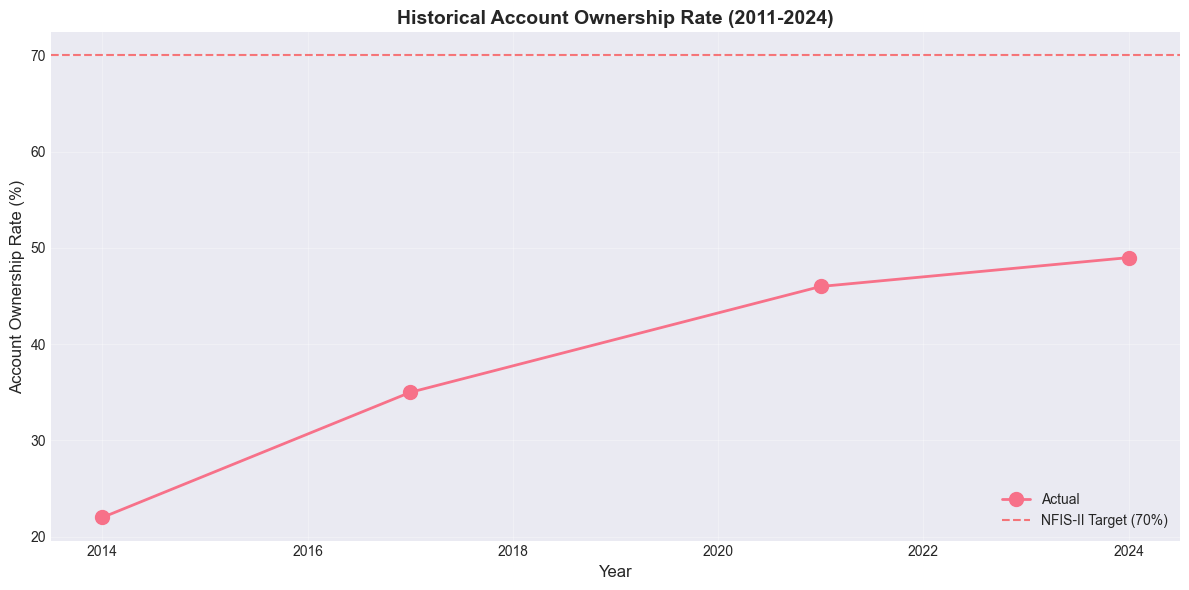


Growth rates:


,year,value,growth_rate
0,2014,22.0,NaN
1,2017,35.0,59.090909
2,2021,46.0,31.428571
5,2024,49.0,6.521739


In [4]:
# Visualize historical trend
plt.figure(figsize=(12, 6))
plt.plot(acc_own_ts['year'], acc_own_ts['value'], 'o-', linewidth=2, markersize=10, label='Actual')
plt.axhline(70, color='red', linestyle='--', alpha=0.5, label='NFIS-II Target (70%)')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Account Ownership Rate (%)', fontsize=12)
plt.title('Historical Account Ownership Rate (2011-2024)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/historical_account_ownership.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate growth rates
acc_own_ts['growth_rate'] = acc_own_ts['value'].pct_change() * 100
print("\nGrowth rates:")
display(acc_own_ts[['year', 'value', 'growth_rate']])

## Section 2: Baseline Trend Models

In [5]:
# Fit linear trend
linear_model, linear_metrics = fit_linear_trend(acc_own_ts)

print("=== LINEAR TREND MODEL ===")
print(f"Formula: y = {linear_metrics['intercept']:.2f} + {linear_metrics['slope']:.2f} × year")
print(f"R² = {linear_metrics['R2']:.4f}")
print(f"RMSE = {linear_metrics['RMSE']:.2f}")
print(f"\nInterpretation: Account ownership increases by {linear_metrics['slope']:.2f}pp per year")

=== LINEAR TREND MODEL ===
Formula: y = -5427.22 + 2.71 × year
R² = 0.9444
RMSE = 2.50

Interpretation: Account ownership increases by 2.71pp per year


In [6]:
# Fit log-linear trend
loglinear_model, loglinear_metrics = fit_loglinear_trend(acc_own_ts)

print("\n=== LOG-LINEAR TREND MODEL ===")
print(f"Formula: log(y) = {loglinear_metrics['intercept']:.2f} + {loglinear_metrics['slope']:.4f} × year")
print(f"R² = {loglinear_metrics['R2']:.4f}")
print(f"RMSE = {loglinear_metrics['RMSE']:.2f}")
print(f"\nInterpretation: Account ownership grows at {loglinear_metrics['slope']*100:.2f}% per year (compound)")


=== LOG-LINEAR TREND MODEL ===
Formula: log(y) = -154.76 + 0.0784 × year
R² = 0.8733
RMSE = 3.78

Interpretation: Account ownership grows at 7.84% per year (compound)


In [7]:
# Compare model fit
print("\n=== MODEL COMPARISON ===")
comparison = pd.DataFrame({
    'Model': ['Linear', 'Log-Linear'],
    'R²': [linear_metrics['R2'], loglinear_metrics['R2']],
    'RMSE': [linear_metrics['RMSE'], loglinear_metrics['RMSE']]
})
display(comparison)

best_model = 'Log-Linear' if loglinear_metrics['R2'] > linear_metrics['R2'] else 'Linear'
print(f"\n✓ Best model: {best_model} (higher R²)")


=== MODEL COMPARISON ===


,Model,R²,RMSE
0,Linear,0.944406,2.500862
1,Log-Linear,0.873275,3.775781



✓ Best model: Linear (higher R²)


In [8]:
# Generate baseline forecasts (2025-2030)
forecast_years = list(range(2025, 2031))

linear_forecast = generate_trend_forecast(linear_model, forecast_years, 'linear')
loglinear_forecast = generate_trend_forecast(loglinear_model, forecast_years, 'log-linear')

print("\n=== BASELINE FORECASTS (2025-2030) ===")
baseline_comparison = pd.DataFrame({
    'Year': forecast_years,
    'Linear': linear_forecast['forecast'].values,
    'Log-Linear': loglinear_forecast['forecast'].values
})
display(baseline_comparison)


=== BASELINE FORECASTS (2025-2030) ===


,Year,Linear,Log-Linear
0,2025,54.241379,58.115164
1,2026,56.948276,62.857619
2,2027,59.655172,67.987012
3,2028,62.362069,73.534915
4,2029,65.068966,79.535473
5,2030,67.775862,86.025619


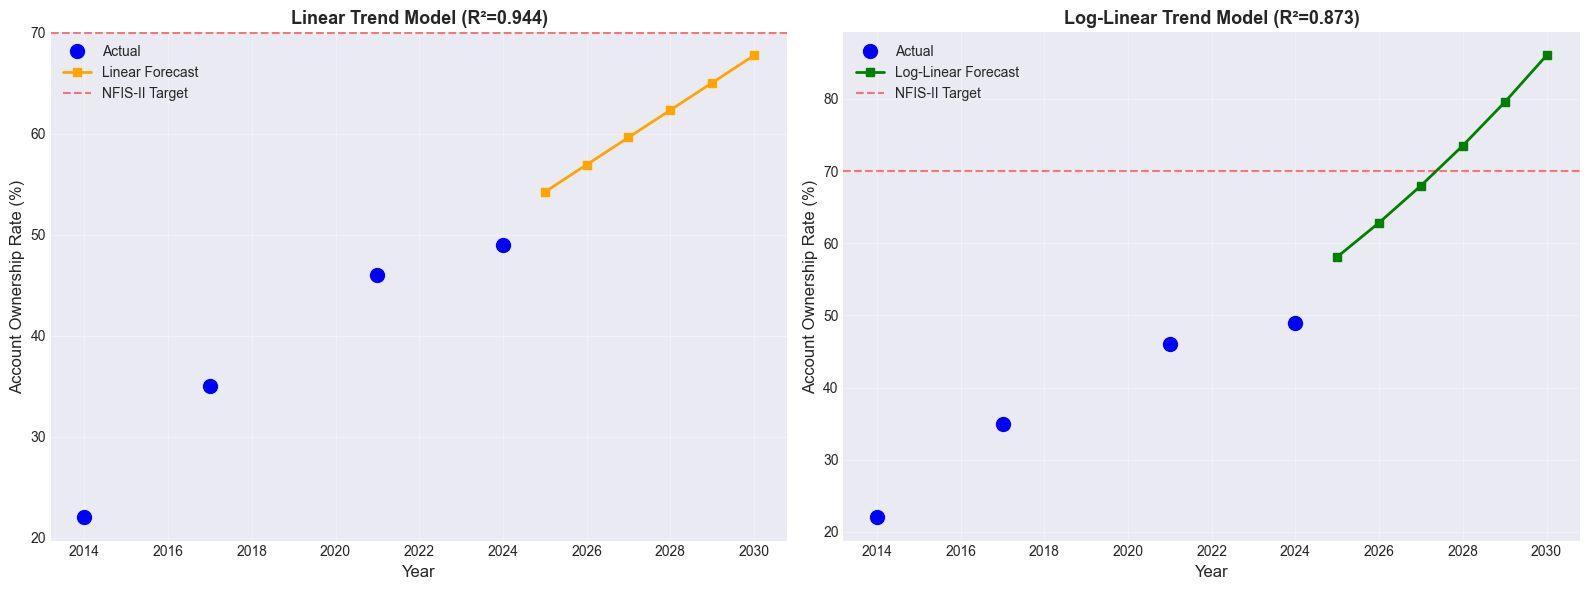

In [9]:
# Visualize trend models
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Historical + Linear forecast
ax1.plot(acc_own_ts['year'], acc_own_ts['value'], 'o', markersize=10, label='Actual', color='blue')
ax1.plot(linear_forecast['year'], linear_forecast['forecast'], 's-', linewidth=2, 
         label='Linear Forecast', color='orange')
ax1.axhline(70, color='red', linestyle='--', alpha=0.5, label='NFIS-II Target')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Account Ownership Rate (%)', fontsize=12)
ax1.set_title(f'Linear Trend Model (R²={linear_metrics["R2"]:.3f})', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Historical + Log-linear forecast
ax2.plot(acc_own_ts['year'], acc_own_ts['value'], 'o', markersize=10, label='Actual', color='blue')
ax2.plot(loglinear_forecast['year'], loglinear_forecast['forecast'], 's-', linewidth=2, 
         label='Log-Linear Forecast', color='green')
ax2.axhline(70, color='red', linestyle='--', alpha=0.5, label='NFIS-II Target')
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Account Ownership Rate (%)', fontsize=12)
ax2.set_title(f'Log-Linear Trend Model (R²={loglinear_metrics["R2"]:.3f})', fontsize=13, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/trend_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 3: Event-Augmented Forecasts

In [10]:
# Combine trend with event impacts
baseline_year = 2021
baseline_value = acc_own_ts[acc_own_ts['year'] == baseline_year]['value'].values[0]

event_augmented = combine_trend_and_events(
    loglinear_forecast,
    events_df,
    impact_links_df,
    'ACC_OWNERSHIP',
    baseline_year,
    baseline_value,
    model_type='log-linear'
)

print("=== EVENT-AUGMENTED FORECAST ===")
display(event_augmented[['year', 'forecast', 'event_impact', 'combined_forecast']])

=== EVENT-AUGMENTED FORECAST ===


,year,forecast,event_impact,combined_forecast
0,2025,58.115164,12.185945,70.301109
1,2026,62.857619,12.190000,75.047619
2,2027,67.987012,12.190000,80.177012
3,2028,73.534915,12.190000,85.724915
4,2029,79.535473,12.190000,91.725473
5,2030,86.025619,12.190000,98.215619


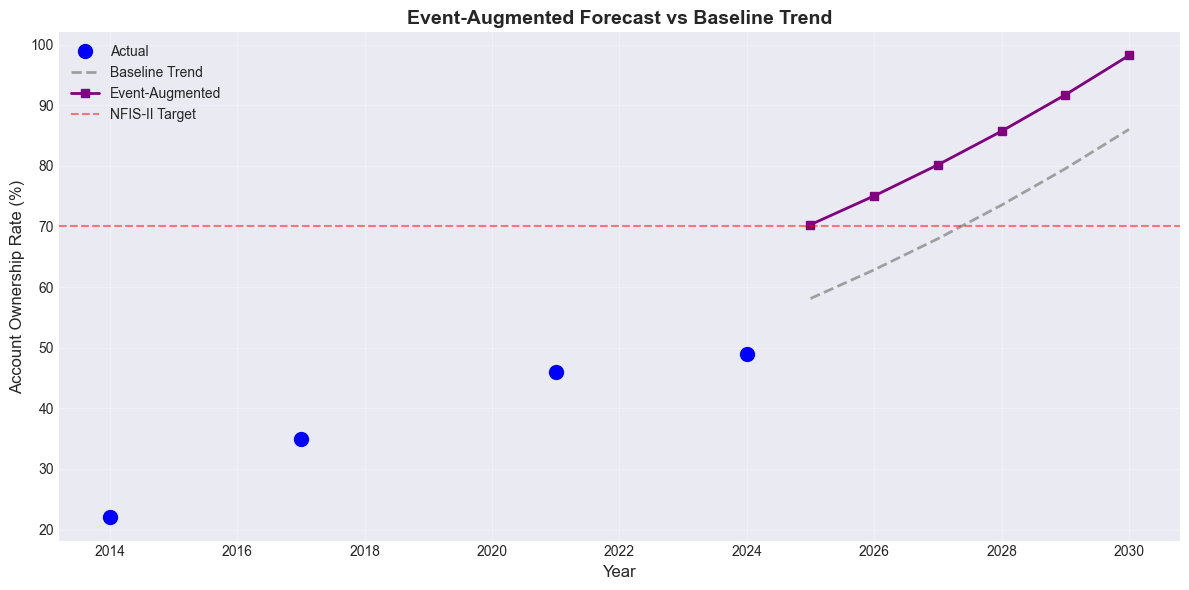


Event impact by 2030: +12.2pp


In [11]:
# Visualize event-augmented forecast
plt.figure(figsize=(12, 6))
plt.plot(acc_own_ts['year'], acc_own_ts['value'], 'o', markersize=10, label='Actual', color='blue')
plt.plot(event_augmented['year'], event_augmented['forecast'], '--', linewidth=2, 
         label='Baseline Trend', color='gray', alpha=0.7)
plt.plot(event_augmented['year'], event_augmented['combined_forecast'], 's-', linewidth=2, 
         label='Event-Augmented', color='purple')
plt.axhline(70, color='red', linestyle='--', alpha=0.5, label='NFIS-II Target')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Account Ownership Rate (%)', fontsize=12)
plt.title('Event-Augmented Forecast vs Baseline Trend', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('../reports/event_augmented_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nEvent impact by 2030: +{event_augmented[event_augmented['year']==2030]['event_impact'].values[0]:.1f}pp")

## Section 4: Scenario Analysis

In [12]:
# Generate three scenarios
optimistic = generate_scenario_forecast(event_augmented, 'optimistic', impact_multiplier=1.3)
base = generate_scenario_forecast(event_augmented, 'base', impact_multiplier=1.0)
pessimistic = generate_scenario_forecast(event_augmented, 'pessimistic', impact_multiplier=0.7)

print("=== SCENARIO FORECASTS ===")
scenarios_df = pd.DataFrame({
    'Year': forecast_years,
    'Optimistic': optimistic['scenario_forecast'].values,
    'Base': base['scenario_forecast'].values,
    'Pessimistic': pessimistic['scenario_forecast'].values
})
display(scenarios_df)

# Calculate scenario range
scenario_range = calculate_scenario_range([optimistic, base, pessimistic])
print("\nScenario ranges:")
display(scenario_range)

=== SCENARIO FORECASTS ===


,Year,Optimistic,Base,Pessimistic
0,2025,73.956892,70.301109,66.645325
1,2026,78.704619,75.047619,71.390619
2,2027,83.834012,80.177012,76.520012
3,2028,89.381915,85.724915,82.067915
4,2029,95.382473,91.725473,88.068473
5,2030,100.000000,98.215619,94.558619



Scenario ranges:


,year,min,max,mean,range
0,2025,66.645325,73.956892,70.301109,7.311567
1,2026,71.390619,78.704619,75.047619,7.314000
2,2027,76.520012,83.834012,80.177012,7.314000
3,2028,82.067915,89.381915,85.724915,7.314000
4,2029,88.068473,95.382473,91.725473,7.314000
5,2030,94.558619,100.000000,97.591413,5.441381


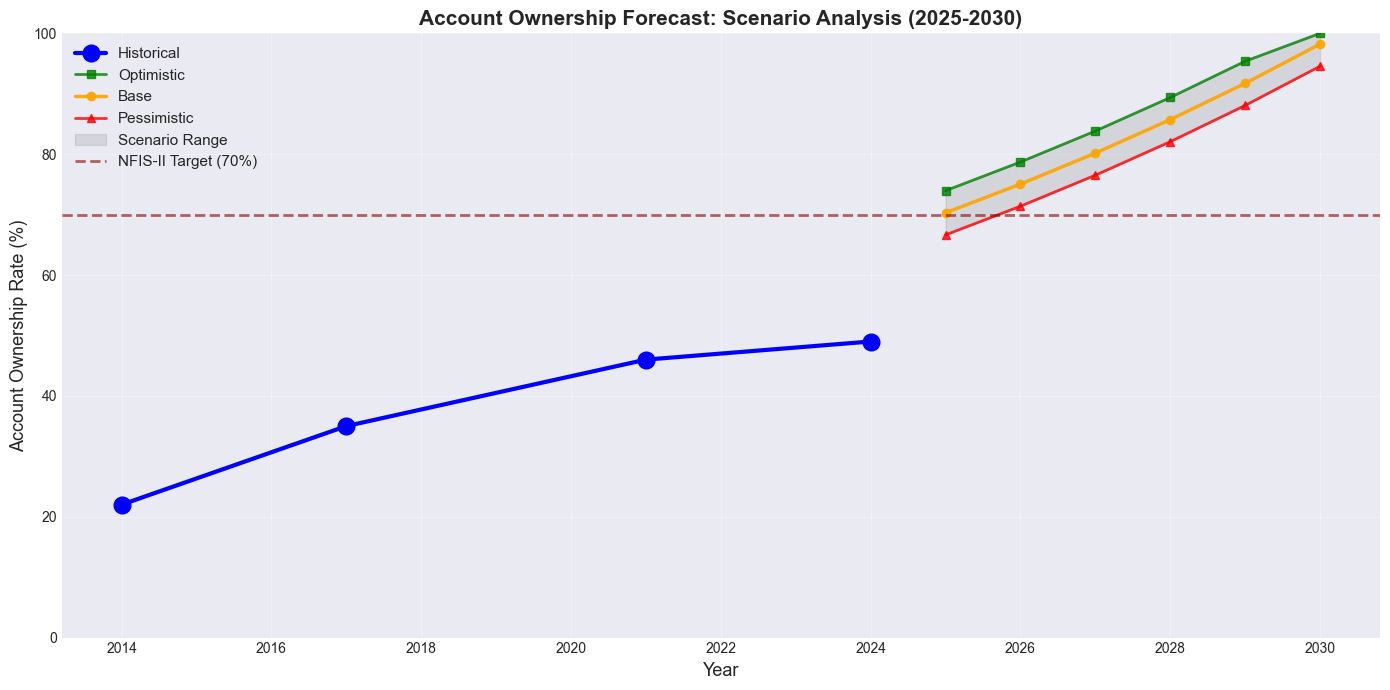

In [13]:
# Visualize scenario fan chart
plt.figure(figsize=(14, 7))

# Historical data
plt.plot(acc_own_ts['year'], acc_own_ts['value'], 'o-', linewidth=3, markersize=12, 
         label='Historical', color='blue', zorder=5)

# Scenarios
plt.plot(optimistic['year'], optimistic['scenario_forecast'], 's-', linewidth=2, 
         label='Optimistic', color='green', alpha=0.8)
plt.plot(base['year'], base['scenario_forecast'], 'o-', linewidth=2.5, 
         label='Base', color='orange', alpha=0.9)
plt.plot(pessimistic['year'], pessimistic['scenario_forecast'], '^-', linewidth=2, 
         label='Pessimistic', color='red', alpha=0.8)

# Fill between scenarios
plt.fill_between(optimistic['year'], pessimistic['scenario_forecast'], 
                 optimistic['scenario_forecast'], alpha=0.2, color='gray', label='Scenario Range')

# Target line
plt.axhline(70, color='darkred', linestyle='--', linewidth=2, alpha=0.6, label='NFIS-II Target (70%)')

plt.xlabel('Year', fontsize=13)
plt.ylabel('Account Ownership Rate (%)', fontsize=13)
plt.title('Account Ownership Forecast: Scenario Analysis (2025-2030)', fontsize=15, fontweight='bold')
plt.legend(loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('../reports/scenario_fan_chart.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 5: Uncertainty Quantification

In [14]:
# Calculate confidence intervals
ci_95 = calculate_confidence_interval(acc_own_ts, loglinear_model, forecast_years, 'log-linear', 0.95)
ci_80 = calculate_confidence_interval(acc_own_ts, loglinear_model, forecast_years, 'log-linear', 0.80)

print("=== CONFIDENCE INTERVALS ===")
print("\n95% Confidence Interval:")
display(ci_95[['year', 'forecast', 'lower', 'upper']])

print("\n80% Confidence Interval:")
display(ci_80[['year', 'forecast', 'lower', 'upper']])

=== CONFIDENCE INTERVALS ===

95% Confidence Interval:


,year,forecast,lower,upper
0,2025,58.115164,24.980940,100.0
1,2026,62.857619,25.723890,100.0
2,2027,67.987012,26.372695,100.0
3,2028,73.534915,26.938156,100.0
4,2029,79.535473,27.430609,100.0
5,2030,86.025619,27.859499,100.0



80% Confidence Interval:


,year,forecast,lower,upper
0,2025,58.115164,40.142396,84.132792
1,2026,62.857619,42.493250,92.979066
2,2027,67.987012,44.895150,100.000000
3,2028,73.534915,47.356063,100.000000
4,2029,79.535473,49.884066,100.000000
5,2030,86.025619,52.487135,100.000000


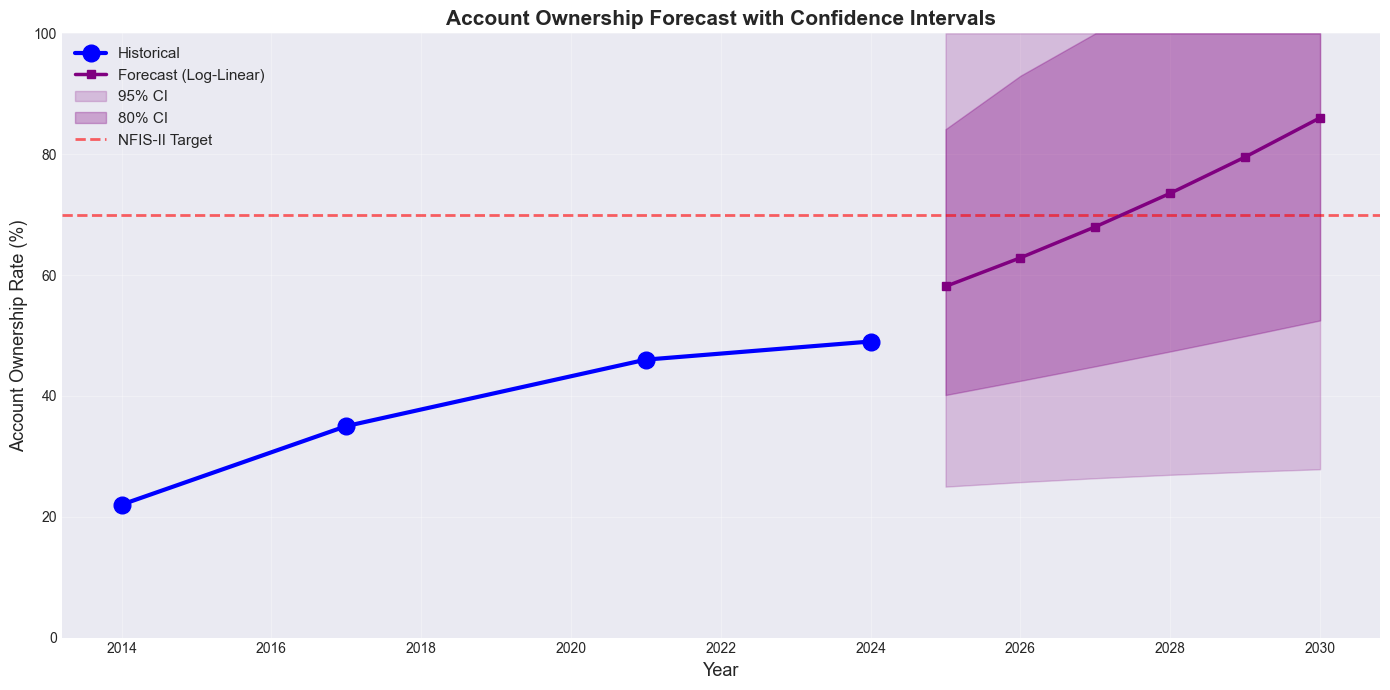

In [15]:
# Visualize uncertainty bands
plt.figure(figsize=(14, 7))

# Historical
plt.plot(acc_own_ts['year'], acc_own_ts['value'], 'o-', linewidth=3, markersize=12, 
         label='Historical', color='blue', zorder=5)

# Forecast
plt.plot(ci_95['year'], ci_95['forecast'], 's-', linewidth=2.5, 
         label='Forecast (Log-Linear)', color='purple', zorder=4)

# Confidence intervals
plt.fill_between(ci_95['year'], ci_95['lower'], ci_95['upper'], 
                 alpha=0.2, color='purple', label='95% CI')
plt.fill_between(ci_80['year'], ci_80['lower'], ci_80['upper'], 
                 alpha=0.3, color='purple', label='80% CI')

# Target
plt.axhline(70, color='red', linestyle='--', linewidth=2, alpha=0.6, label='NFIS-II Target')

plt.xlabel('Year', fontsize=13)
plt.ylabel('Account Ownership Rate (%)', fontsize=13)
plt.title('Account Ownership Forecast with Confidence Intervals', fontsize=15, fontweight='bold')
plt.legend(loc='upper left', fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('../reports/forecast_confidence_intervals.png', dpi=300, bbox_inches='tight')
plt.show()

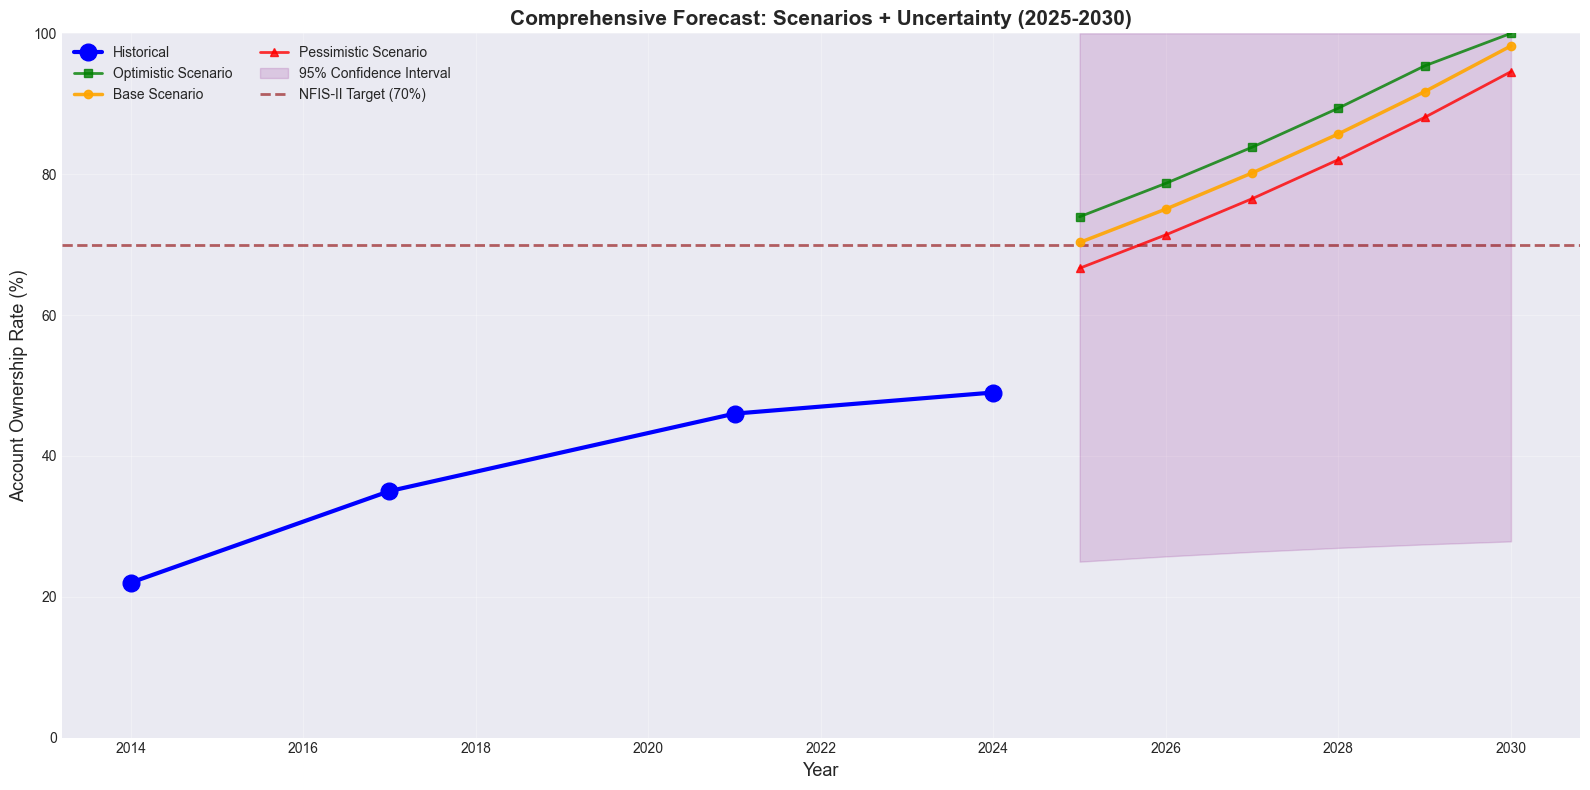

In [16]:
# Combined: Scenarios + Confidence Intervals
plt.figure(figsize=(16, 8))

# Historical
plt.plot(acc_own_ts['year'], acc_own_ts['value'], 'o-', linewidth=3, markersize=12, 
         label='Historical', color='blue', zorder=5)

# Scenarios
plt.plot(optimistic['year'], optimistic['scenario_forecast'], 's-', linewidth=2, 
         label='Optimistic Scenario', color='green', alpha=0.8, zorder=3)
plt.plot(base['year'], base['scenario_forecast'], 'o-', linewidth=2.5, 
         label='Base Scenario', color='orange', alpha=0.9, zorder=4)
plt.plot(pessimistic['year'], pessimistic['scenario_forecast'], '^-', linewidth=2, 
         label='Pessimistic Scenario', color='red', alpha=0.8, zorder=3)

# 95% CI
plt.fill_between(ci_95['year'], ci_95['lower'], ci_95['upper'], 
                 alpha=0.15, color='purple', label='95% Confidence Interval', zorder=1)

# Target
plt.axhline(70, color='darkred', linestyle='--', linewidth=2, alpha=0.6, label='NFIS-II Target (70%)')

plt.xlabel('Year', fontsize=13)
plt.ylabel('Account Ownership Rate (%)', fontsize=13)
plt.title('Comprehensive Forecast: Scenarios + Uncertainty (2025-2030)', fontsize=15, fontweight='bold')
plt.legend(loc='upper left', fontsize=10, ncol=2)
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('../reports/comprehensive_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

## Section 6: Validation & Backtesting

In [17]:
# Backtest: Predict 2024 from 2021 data
backtest_linear = backtest_model(acc_own_ts, 2024, 'linear')
backtest_loglinear = backtest_model(acc_own_ts, 2024, 'log-linear')

print("=== BACKTEST RESULTS (2024 Prediction) ===")
print("\nLinear Model:")
print(f"  Actual: {backtest_linear['actual']:.1f}%")
print(f"  Predicted: {backtest_linear['predicted']:.1f}%")
print(f"  Error: {backtest_linear['error']:.1f}pp ({backtest_linear['error_pct']:.1f}%)")

print("\nLog-Linear Model:")
print(f"  Actual: {backtest_loglinear['actual']:.1f}%")
print(f"  Predicted: {backtest_loglinear['predicted']:.1f}%")
print(f"  Error: {backtest_loglinear['error']:.1f}pp ({backtest_loglinear['error_pct']:.1f}%)")

better_model = 'Log-Linear' if abs(backtest_loglinear['error_pct']) < abs(backtest_linear['error_pct']) else 'Linear'
print(f"\n✓ Better backtest performance: {better_model}")

=== BACKTEST RESULTS (2024 Prediction) ===

Linear Model:
  Actual: 49.0%
  Predicted: 56.9%
  Error: 7.9pp (16.2%)

Log-Linear Model:
  Actual: 49.0%
  Predicted: 65.4%
  Error: 16.4pp (33.5%)

✓ Better backtest performance: Linear


## Section 7: Summary & Recommendations

In [18]:
# Summary table
summary = pd.DataFrame({
    'Year': forecast_years,
    'Baseline Trend': loglinear_forecast['forecast'].values,
    'Event-Augmented': event_augmented['combined_forecast'].values,
    'Optimistic': optimistic['scenario_forecast'].values,
    'Base Scenario': base['scenario_forecast'].values,
    'Pessimistic': pessimistic['scenario_forecast'].values,
    '95% CI Lower': ci_95['lower'].values,
    '95% CI Upper': ci_95['upper'].values
})

print("=== COMPREHENSIVE FORECAST SUMMARY ===")
display(summary.round(1))

# Key insights
print("\n=== KEY INSIGHTS ===")
print(f"1. Current (2024): {acc_own_ts[acc_own_ts['year']==2024]['value'].values[0]:.1f}%")
print(f"2. Base scenario (2030): {base[base['year']==2030]['scenario_forecast'].values[0]:.1f}%")
print(f"3. Optimistic scenario (2030): {optimistic[optimistic['year']==2030]['scenario_forecast'].values[0]:.1f}%")
print(f"4. Pessimistic scenario (2030): {pessimistic[pessimistic['year']==2030]['scenario_forecast'].values[0]:.1f}%")
print(f"5. NFIS-II target (70%): {'Achievable' if optimistic[optimistic['year']==2030]['scenario_forecast'].values[0] >= 70 else 'Challenging'}")
print(f"6. Scenario range (2030): {scenario_range[scenario_range['year']==2030]['range'].values[0]:.1f}pp")
print(f"7. 95% CI width (2030): {ci_95[ci_95['year']==2030]['upper'].values[0] - ci_95[ci_95['year']==2030]['lower'].values[0]:.1f}pp")

=== COMPREHENSIVE FORECAST SUMMARY ===


,Year,Baseline Trend,Event-Augmented,Optimistic,Base Scenario,Pessimistic,95% CI Lower,95% CI Upper
0,2025,58.1,70.3,74.0,70.3,66.6,25.0,100.0
1,2026,62.9,75.0,78.7,75.0,71.4,25.7,100.0
2,2027,68.0,80.2,83.8,80.2,76.5,26.4,100.0
3,2028,73.5,85.7,89.4,85.7,82.1,26.9,100.0
4,2029,79.5,91.7,95.4,91.7,88.1,27.4,100.0
5,2030,86.0,98.2,100.0,98.2,94.6,27.9,100.0



=== KEY INSIGHTS ===
1. Current (2024): 49.0%
2. Base scenario (2030): 98.2%
3. Optimistic scenario (2030): 100.0%
4. Pessimistic scenario (2030): 94.6%
5. NFIS-II target (70%): Achievable
6. Scenario range (2030): 5.4pp
7. 95% CI width (2030): 72.1pp


In [20]:
# Export forecast to CSV
summary.to_csv('../data/processed/account_ownership_forecast.csv', index=False)
print("\n✓ Forecast exported to: data/processed/account_ownership_forecast.csv")


✓ Forecast exported to: data/processed/account_ownership_forecast.csv
